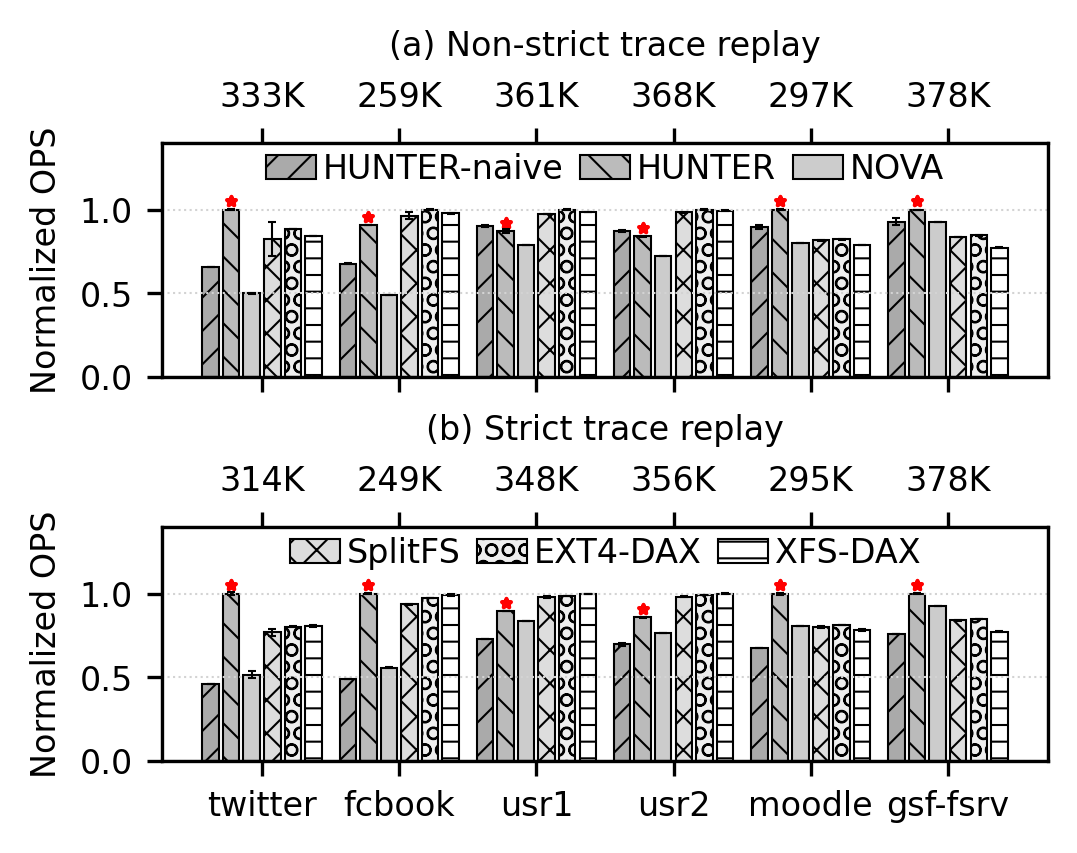

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-fsync", "r") as f:
    df_strict = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# df.drop(df[df['file_system'] == "SplitFS-FIO"].index, inplace=True)
# df_strict.drop(df_strict[df_strict['file_system'] == "SplitFS-FIO"].index, inplace=True)
df.drop(df[df['file_system'] == "PMFS"].index, inplace=True)
df_strict.drop(df_strict[df_strict['file_system'] == "PMFS"].index, inplace=True)
df.drop(df[df['file_system'] == "NOVA-RELAX"].index, inplace=True)
df_strict.drop(df_strict[df_strict['file_system'] == "NOVA-RELAX"].index, inplace=True)

df_orig = df.copy()
df_strict_orig = df_strict.copy()

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(7)))
fig.patch.set_facecolor('white')
bar_width = 0.15
true_bar_width = 0.12
subfig_titles = ["(a) Non-strict trace replay", "(b) Strict trace replay"]
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = [ "#aaaaaa", "#bbbbbb", "#cccccc", "#dddddd", "#eeeeee", "#ffffff"]
cmap = "tab10"
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
workloads = [ "twitter", "facebook", "usr1", "usr2", "moodle", "gsf-filesrv" ]
workloads_name_remap = [ "twitter", "fcbook", "usr1", "usr2", "moodle", "gsf-fsrv" ]

tot = len(fss) * bar_width
x = list(range(1, len(workloads) + 1))

for workload in workloads:
    value = df[(df['trace'] == workload)]['ops'] / df[(df['trace'] == workload)]['ops'].max()
    error = df[(df['trace'] == workload)]['std-ops'] / df[(df['trace'] == workload)]['ops'].max()
    df.loc[(df['trace'] == workload), 'ops'] = value
    df.loc[(df['trace'] == workload), 'std-ops'] = error

for workload in workloads:
    value = df_strict[(df_strict['trace'] == workload)]['ops'] / df_strict[(df_strict['trace'] == workload)]['ops'].max()
    error = df_strict[(df_strict['trace'] == workload)]['std-ops'] / df_strict[(df_strict['trace'] == workload)]['ops'].max()
    df_strict.loc[(df_strict['trace'] == workload), 'ops'] = value
    df_strict.loc[(df_strict['trace'] == workload), 'std-ops'] = error

def add_explanation_and_title(fig, ax, exp, title, title_pad=10, title_fontsize=8, exp_fontsize=6):
    lable_pad = title_pad
    ax.set_xlabel(title, fontsize=title_fontsize, labelpad=lable_pad) 
    return [exp, title, title_pad, title_fontsize, exp_fontsize]
    
def adjust_explanation(fig, axes, context):
    exp, title, title_pad, title_fontsize, exp_fontsize = context
    
    # plt.tight_layout()
    # fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    fig.savefig("./temp.pdf", bbox_inches='tight', pad_inches=0)
    # for ax in fig.axes:
        # plt.tight_layout()
        # Get the first xtick label
    midpoint = (0.5, 0.5)
    for idx, ax in enumerate(axes):
        xtick_label = ax.get_xticklabels()[0]
        label_bbox1 = xtick_label.get_window_extent()
        # print(label_bbox1)
        figure_pos1 = label_bbox1.transformed(ax.transAxes.inverted())
        
        # Get the xlabel object
        xlable = ax.xaxis.label
        label_bbox2 = xlable.get_window_extent()
        # print(label_bbox2)
        figure_pos2 = label_bbox2.transformed(ax.transAxes.inverted())
        midpoint = (0.5, (figure_pos1.y0 + figure_pos2.y1) / 2 + 0.08)
        
    print(midpoint)
    for idx, ax in enumerate(axes):
        explanation = ax.text(midpoint[0], midpoint[1], exp, ha='center', fontsize=exp_fontsize, transform=ax.transAxes)   

        # fig.savefig("./temp" + str(idx) + ".pdf", bbox_inches='tight', pad_inches=0)
        # # adjust midpoint
        # explanation_bbox = explanation.get_window_extent().transformed(ax.transAxes.inverted())
        # height = explanation_bbox.height
        # midpoint = (midpoint[0], midpoint[1] + height)
        # explanation.set_position(midpoint)

bars = []
modes = [ "non-strict", "strict" ]
for fig_idx, mode in enumerate(modes):
    subfig = plt.subplot(2, 1, fig_idx + 1)
    df = df if fig_idx == 0 else df_strict
    df_orig = df_orig if fig_idx == 0 else df_strict_orig
    real_bws = []
    for idx, fs in enumerate(fss):
        points = []
        for pivot in x:
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        bws = []
        bws_error = []
        if fig_idx == 1 and fs == "HUNTER":
            fs = "HUNTER-SYNC"
        for workload in workloads:
            bws.append(df[(df['file_system'] == fs) & (df['trace'] == workload)]['ops'].iloc[0])
            bws_error.append(df[(df['file_system'] == fs) & (df['trace'] == workload)]['std-ops'].iloc[0])
            if fs == "HUNTER-J":
                real_bws.append(df_orig[(df_orig['file_system'] == "HUNTER-J") & (df_orig['trace'] == workload)]['ops'].iloc[0])

        bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], color=colors[idx], edgecolor='black', linewidth=0.5)
        plt.errorbar(points, bws, yerr=bws_error, fmt='none', ecolor='black', elinewidth=0.5, capsize=1, capthick=0.5)
        if fs == "HUNTER-J":
            plt.scatter(points, [ bw + 0.05 for bw in bws], marker='*', color='red', s=5)
        
        # plt.bar(points, bws, width=bar_width, color='none', edgecolor='white', linewidth=0.5)
        bars.append(bar)

    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    
    plt.ylim(0, 1.4)
    if fig_idx == 1:
        plt.xticks(x, labels=workloads_name_remap, fontsize=8)
        plt.title(subfig_titles[fig_idx], fontsize=8)
    else:
        plt.xticks(x, labels=[], fontsize=8)
        plt.title(subfig_titles[fig_idx], fontsize=8)
    plt.yticks([0, 0.5, 1], fontsize=8)
    plt.ylabel('Normalized OPS', fontsize=8)
    xlim = ax.get_xlim()

    ax.twiny()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    plt.xlim(xlim)
    plt.xticks(x, labels= [ str(round(real_bw / 1000)) + "K" for real_bw in real_bws], fontsize=8)


fss.replace("SplitFS-FILEBENCH", "SplitFS", inplace=True)
fss.replace("HUNTER", "HUNTER-naive", inplace=True)
fss.replace("HUNTER-J", "HUNTER", inplace=True)
legend_labels = fss

# fig.legend(bars, legend_labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)

# fig.legend(bars, legend_labels, loc='upper left', bbox_to_anchor=(1, 0.7), ncol=1, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)

steps = [3, 0, 3, 0]
cols = [3, 3, 3, 3]
for ax_id, ax in enumerate(fig.axes):
    if steps[ax_id] == 0:
        continue
    start = sum(steps[:ax_id])
    end = start + steps[ax_id]
    
    leg = ax.legend(bars[start : end], legend_labels[start : end], loc='upper center', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes, ncol=cols[ax_id], fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5, labelspacing=0.1, borderpad=0.2)


plt.tight_layout(pad=0.4)
plt.savefig("./FIG-Trace.pdf", bbox_inches='tight', pad_inches=0.1)
